In [1]:
import numpy as np
import matplotlib.pyplot as plt

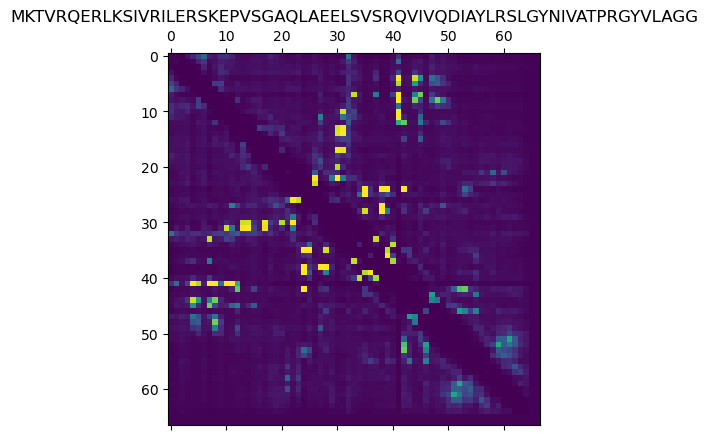

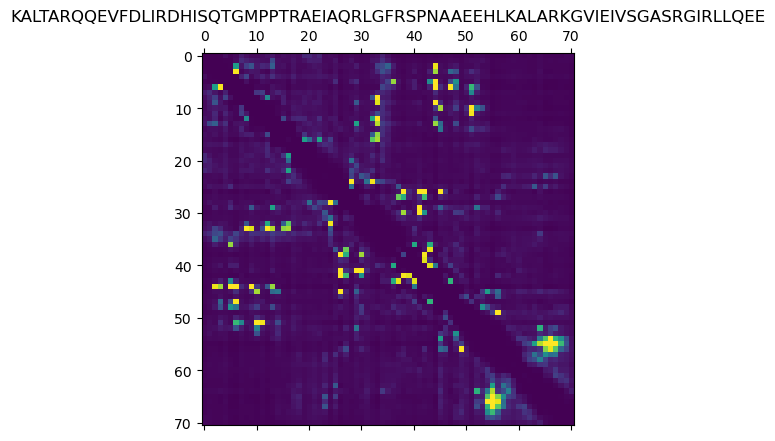

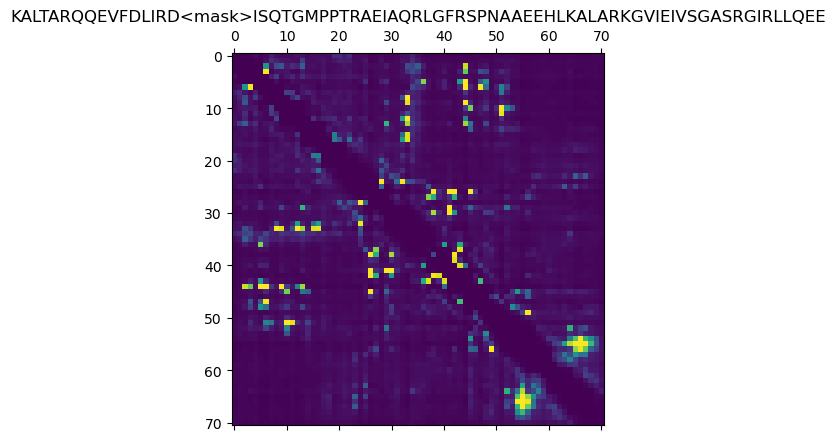

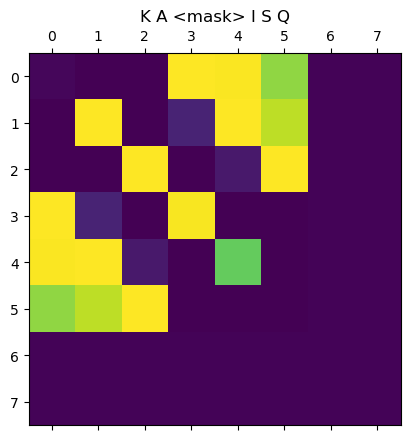

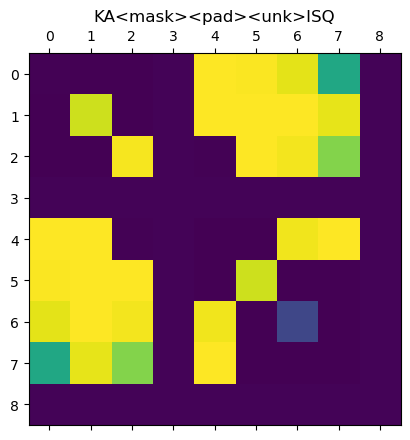

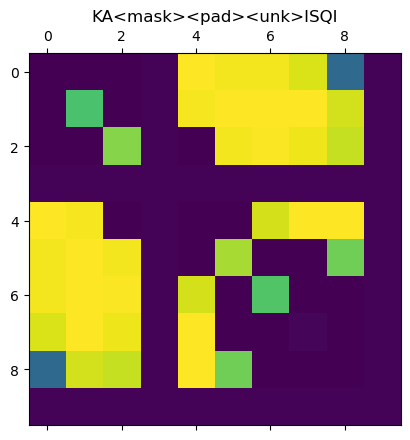

In [56]:
import torch
import esm

# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D() #esm.pretrained.esm2_t12_35M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein3",  "K A <mask> I S Q"),
    ("protein4", "KA<mask><pad><unk>ISQ"),
    ("protein4", "KA<mask><pad><unk>ISQI")
]

batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[6], return_contacts=True)
token_representations = results["representations"][6]

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, tokens_len in enumerate(batch_lens):
    sequence_representations.append(token_representations[i, 1 : tokens_len - 1])#.mean(0))

# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), tokens_len, attention_contacts in zip(data, batch_lens, results["contacts"]):
    plt.matshow(attention_contacts[: tokens_len, : tokens_len])
    plt.title(seq)
    plt.show()

In [36]:
batch_lens

tensor([67, 73, 73,  8,  9, 10])

In [30]:
batch_tokens

tensor([[ 0, 20, 15, 11,  7, 10, 16,  9, 10,  4, 15,  8, 12,  7, 10, 12,  4,  9,
         10,  8, 15,  9, 14,  7,  8,  6,  5, 16,  4,  5,  9,  9,  4,  8,  7,  8,
         10, 16,  7, 12,  7, 16, 13, 12,  5, 19,  4, 10,  8,  4,  6, 19, 17, 12,
          7,  5, 11, 14, 10,  6, 19,  7,  4,  5,  6,  6,  2,  1,  1,  1,  1,  1,
          1],
        [ 0, 15,  5,  4, 11,  5, 10, 16, 16,  9,  7, 18, 13,  4, 12, 10, 13, 21,
         12,  8, 16, 11,  6, 20, 14, 14, 11, 10,  5,  9, 12,  5, 16, 10,  4,  6,
         18, 10,  8, 14, 17,  5,  5,  9,  9, 21,  4, 15,  5,  4,  5, 10, 15,  6,
          7, 12,  9, 12,  7,  8,  6,  5,  8, 10,  6, 12, 10,  4,  4, 16,  9,  9,
          2],
        [ 0, 15,  5,  4, 11,  5, 10, 16, 16,  9,  7, 18, 13,  4, 12, 10, 13, 32,
         12,  8, 16, 11,  6, 20, 14, 14, 11, 10,  5,  9, 12,  5, 16, 10,  4,  6,
         18, 10,  8, 14, 17,  5,  5,  9,  9, 21,  4, 15,  5,  4,  5, 10, 15,  6,
          7, 12,  9, 12,  7,  8,  6,  5,  8, 10,  6, 12, 10,  4,  4, 16,  9,  9,


In [31]:
results.keys()

dict_keys(['logits', 'representations', 'attentions', 'contacts'])

In [32]:
[len(i[1]) for i in data]

[65, 71, 76, 16, 21, 22]

In [33]:
model.embed_tokens(batch_tokens).shape, model.embed_tokens(batch_tokens)

(torch.Size([6, 73, 320]),
 tensor([[[-1.9543e-01, -2.7515e-01, -1.4941e-01,  ...,  1.2744e-01,
           -1.0431e-01, -6.4697e-02],
          [-1.2018e-01, -6.2561e-02, -3.1189e-02,  ..., -2.5317e-01,
            4.7913e-02, -8.8928e-02],
          [-9.7595e-02,  1.5762e-02,  3.3600e-02,  ...,  3.4027e-03,
            2.2369e-02,  2.8732e-02],
          ...,
          [-2.2253e-01, -9.6045e-01, -5.9753e-02,  ..., -2.2998e-01,
           -9.4849e-02,  3.9136e-01],
          [-2.2253e-01, -9.6045e-01, -5.9753e-02,  ..., -2.2998e-01,
           -9.4849e-02,  3.9136e-01],
          [-2.2253e-01, -9.6045e-01, -5.9753e-02,  ..., -2.2998e-01,
           -9.4849e-02,  3.9136e-01]],
 
         [[-1.9543e-01, -2.7515e-01, -1.4941e-01,  ...,  1.2744e-01,
           -1.0431e-01, -6.4697e-02],
          [-9.7595e-02,  1.5762e-02,  3.3600e-02,  ...,  3.4027e-03,
            2.2369e-02,  2.8732e-02],
          [-6.6711e-02, -1.1932e-02,  8.6288e-03,  ...,  1.4633e-02,
           -4.3945e-02, -1.934

In [34]:
results["representations"][6].shape, results["representations"][6]

(torch.Size([6, 73, 320]),
 tensor([[[ 2.2311e-01,  5.6614e-01,  1.1388e-01,  ...,  1.0212e+00,
           -1.9001e-01, -6.8704e-01],
          [ 4.8727e-01,  2.4047e-01, -1.9778e-01,  ...,  6.3980e-01,
           -8.0584e-02, -3.4494e-01],
          [-1.0653e-01, -3.5282e-01, -1.0218e-01,  ..., -1.5477e-01,
            2.4644e-01,  7.9690e-03],
          ...,
          [ 5.7462e-02,  1.4871e-01,  2.7259e-01,  ...,  2.4187e-01,
           -5.5117e-02, -2.6239e-01],
          [ 3.8684e-02,  8.9944e-03,  8.7100e-02,  ...,  2.1241e-01,
           -1.7877e-01, -2.0659e-01],
          [ 3.2754e-01,  8.1795e-02,  1.3436e-01,  ...,  2.6177e-01,
           -2.2451e-01, -2.8993e-01]],
 
         [[ 3.8574e-01,  6.9252e-01,  2.1286e-01,  ...,  9.7422e-01,
           -2.2145e-01, -6.5650e-01],
          [ 1.9615e-01,  3.3133e-01, -2.9503e-01,  ...,  7.5257e-01,
           -1.4180e-01, -4.3786e-01],
          [ 3.9016e-01,  1.1946e-01, -5.5802e-01,  ...,  1.9097e-01,
            2.5611e-01, -3.246

In [35]:
word_embed = model.embed_tokens(batch_tokens)
token_embed = results["representations"][6]

embed = word_embed + token_embed
embed.shape, embed

(torch.Size([6, 73, 320]),
 tensor([[[ 2.7674e-02,  2.9100e-01, -3.5537e-02,  ...,  1.1486e+00,
           -2.9432e-01, -7.5174e-01],
          [ 3.6709e-01,  1.7791e-01, -2.2897e-01,  ...,  3.8662e-01,
           -3.2671e-02, -4.3387e-01],
          [-2.0412e-01, -3.3705e-01, -6.8577e-02,  ..., -1.5137e-01,
            2.6881e-01,  3.6701e-02],
          ...,
          [-1.6507e-01, -8.1174e-01,  2.1283e-01,  ...,  1.1888e-02,
           -1.4997e-01,  1.2897e-01],
          [-1.8385e-01, -9.5145e-01,  2.7347e-02,  ..., -1.7569e-02,
           -2.7362e-01,  1.8477e-01],
          [ 1.0501e-01, -8.7865e-01,  7.4608e-02,  ...,  3.1788e-02,
           -3.1936e-01,  1.0143e-01]],
 
         [[ 1.9030e-01,  4.1737e-01,  6.3450e-02,  ...,  1.1017e+00,
           -3.2576e-01, -7.2119e-01],
          [ 9.8556e-02,  3.4710e-01, -2.6143e-01,  ...,  7.5597e-01,
           -1.1943e-01, -4.0913e-01],
          [ 3.2345e-01,  1.0753e-01, -5.4939e-01,  ...,  2.0561e-01,
            2.1216e-01, -5.180

In [39]:
token_representations.shape, token_representations

(torch.Size([6, 73, 320]),
 tensor([[[ 2.2311e-01,  5.6614e-01,  1.1388e-01,  ...,  1.0212e+00,
           -1.9001e-01, -6.8704e-01],
          [ 4.8727e-01,  2.4047e-01, -1.9778e-01,  ...,  6.3980e-01,
           -8.0584e-02, -3.4494e-01],
          [-1.0653e-01, -3.5282e-01, -1.0218e-01,  ..., -1.5477e-01,
            2.4644e-01,  7.9690e-03],
          ...,
          [ 5.7462e-02,  1.4871e-01,  2.7259e-01,  ...,  2.4187e-01,
           -5.5117e-02, -2.6239e-01],
          [ 3.8684e-02,  8.9944e-03,  8.7100e-02,  ...,  2.1241e-01,
           -1.7877e-01, -2.0659e-01],
          [ 3.2754e-01,  8.1795e-02,  1.3436e-01,  ...,  2.6177e-01,
           -2.2451e-01, -2.8993e-01]],
 
         [[ 3.8574e-01,  6.9252e-01,  2.1286e-01,  ...,  9.7422e-01,
           -2.2145e-01, -6.5650e-01],
          [ 1.9615e-01,  3.3133e-01, -2.9503e-01,  ...,  7.5257e-01,
           -1.4180e-01, -4.3786e-01],
          [ 3.9016e-01,  1.1946e-01, -5.5802e-01,  ...,  1.9097e-01,
            2.5611e-01, -3.246

In [53]:
len(sequence_representations), sequence_representations[0].shape

(6, torch.Size([320]))

In [9]:
len(alphabet.all_toks), alphabet.all_toks

(33,
 ['<cls>',
  '<pad>',
  '<eos>',
  '<unk>',
  'L',
  'A',
  'G',
  'V',
  'S',
  'E',
  'R',
  'T',
  'I',
  'D',
  'P',
  'K',
  'Q',
  'N',
  'F',
  'Y',
  'M',
  'H',
  'W',
  'C',
  'X',
  'B',
  'U',
  'Z',
  'O',
  '.',
  '-',
  '<null_1>',
  '<mask>'])

In [44]:
li = """'L',
  'A',
  'G',
  'V',
  'S',
  'E',
  'R',
  'T',
  'I',
  'D',
  'P',
  'K',
  'Q',
  'N',
  'F',
  'Y',
  'M',
  'H',
  'W',
  'C',
  'X',
  'B',
  'U',
  'Z',
  'O'""".split()

li = [i[1] for i in li]

len(li), sorted(li)

(25,
 ['A',
  'B',
  'C',
  'D',
  'E',
  'F',
  'G',
  'H',
  'I',
  'K',
  'L',
  'M',
  'N',
  'O',
  'P',
  'Q',
  'R',
  'S',
  'T',
  'U',
  'V',
  'W',
  'X',
  'Y',
  'Z'])

In [9]:
model

ESM2(
  (embed_tokens): Embedding(33, 320, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=320, out_features=320, bias=True)
        (v_proj): Linear(in_features=320, out_features=320, bias=True)
        (q_proj): Linear(in_features=320, out_features=320, bias=True)
        (out_proj): Linear(in_features=320, out_features=320, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=320, out_features=1280, bias=True)
      (fc2): Linear(in_features=1280, out_features=320, bias=True)
      (final_layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=320, out_features=320, bias=True)
        (v_proj): Linear(in_features=320, out_features=320, bias=True)
        (